# Churn Analysis - Time Related

In this notebook I'll create new **time-related variables** that hopefully will capture the possibility of a partilar customer churn, or not, the company. First is important to keep in mind that the dataset is originally presented in a **transactional level**, in other words, every line corresponds to transaction made by a customer in a particular date. In order to proceed with the churn analysis, one has to transform the dataset to a **summary level**, where every line corresponds to a specific customer. To complete this task, some data preprocessing has to be made. 

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Folders
analysis_folder = os.getcwd()
input_data = os.path.join(analysis_folder, 'challenge.json')

# Open dataset (transactional level)
df_original = pd.read_json(input_data)

## Time Variable
Converting the `register_date` variable to the pandas *datetime* format.

In [2]:
datetime_format = '%Y-%m-%dT%H:%M:%SZ'
df_original['register_date'] = pd.to_datetime(df_original['register_date'], format=datetime_format)

## Feature Engineering

In order to create the new variables I'll need the identification of each customer and the date of transaction, this could be found in the `customer_code` and `register_date`. In addition, one can also process numerical variables as the average value throughout an order. 

The numerical variables that I choose are `quantity`, `unit_price` and `total_price`.

In [3]:
numerical_features = ['quantity', 'unit_price', 'total_price']
summary_features = ['customer_code', 'register_date']

total_features = summary_features + numerical_features

# sort dataset according with the customer ID and the date of the transaction
df = df_original[total_features].sort_values(summary_features).copy()

df.tail()

,customer_code,register_date,quantity,unit_price,total_price
45647,837,2018-06-25,3,5.94,1201.36
78870,837,2018-06-25,6,15.57,1201.36
105681,837,2018-06-25,1,89.68,1201.36
179936,837,2018-06-25,1,69.93,1201.36
193661,837,2018-06-25,6,23.77,1201.36


<span style="color:red"> **NOTE** </span>: The `total_price` variable seems to have the same value for a particular `customer_code` and `register_date`. 

Let's check this behavior!

In [4]:
df[(df['customer_code']==837) & (df['register_date']=='2018-06-25')]

,customer_code,register_date,quantity,unit_price,total_price
5446,837,2018-06-25,10,41.36,1201.36
6778,837,2018-06-25,2,17.89,1201.36
14205,837,2018-06-25,6,24.92,1201.36
44685,837,2018-06-25,1,188.99,1201.36
45647,837,2018-06-25,3,5.94,1201.36
78870,837,2018-06-25,6,15.57,1201.36
105681,837,2018-06-25,1,89.68,1201.36
179936,837,2018-06-25,1,69.93,1201.36
193661,837,2018-06-25,6,23.77,1201.36


The `total_price` variable is defined as the sum of the product between the `quantity` and `unit_price` variables for a particular order. An order can be described as all the transactions of a customer in a day. One can see from the snapshot of the dataframe showed above that the customer **837** made a total of **13** transactions during the date **2018-06-25**. We can also infer that the order made by this customer in this date has a total price of **$1201.36**.

Therefore, I won't use the `total_price` variable during the feature engineering process, since this varible can be inferred in the **summary level** dataset. But, on the other hand, I'll create a new variable called `items_price` which represents the price paid for the transaction.

* **items_price**: Product between the price of the item and the quantity of the item in that transaction.

In [5]:
df.drop(labels='total_price', axis=1, inplace=True)

# create new feature
df.loc[:,'items_price'] = df['quantity'] * df['unit_price']
df.drop(labels='unit_price', axis=1, inplace=True)

df.tail()

,customer_code,register_date,quantity,items_price
45647,837,2018-06-25,3,17.82
78870,837,2018-06-25,6,93.42
105681,837,2018-06-25,1,89.68
179936,837,2018-06-25,1,69.93
193661,837,2018-06-25,6,142.62


### Observation Period
To continue with the process of creating time-related features for the **summary level** dataset, one has to define an observation period. To do so, I'll define this period as the time interval from the first transaction order and the creation of the dataset, last transaction order, counting by days.

In [6]:
# use Pandas DateTimeIndex.to_period() to convert the original Index 
# to a PeriodIndex which is useful for time-wise grouping and truncating
freq = 'D'
df = df.set_index('register_date').to_period(freq)

observation_period_end = df.index.max()
print('observation_period_end = %s' % observation_period_end)

# get only data inside the observation period and reset the indexes
df = df.loc[(df.index <= observation_period_end)].reset_index()

observation_period_end = 2018-07-08


### Group Customers
Group the dataset by `customers` and create new features based on the transaction frequency done by each of them. This is a crucial step to transform the dataset from a **transactional level** into a **summary level**.

In [7]:
# Pandas groupby
period_groupby = df.groupby(['register_date', 'customer_code'], sort=False, as_index=False)

# Sum numerical values of groupby
period_transactions = period_groupby.sum()

Note that the dataset now has one order per row and the numerical variables are all summed up, as showed bellow.

In [8]:
period_transactions.tail()

,register_date,customer_code,quantity,items_price
22040,2016-11-23,837,27,1021.55
22041,2017-02-09,837,131,13903.74
22042,2017-08-16,837,43,1121.97
22043,2017-11-22,837,92,2547.08
22044,2018-06-25,837,36,1201.36


### Create New Time-Related Variables
Now I'll present the new time-related variables that could be written from a summary level database (finally!).

`n_orders` - Represents the total number of orders made by each customer throughout the entire timespan of the dataset.

`age` - The number of days that each customer is under observation. In other words, this is the number of days between the first order made by the customer and the final of the observation period, which for this analysis is the date where the dataset was created.

`recency` - The day when the customer realized his/her last order. In other words, it is the most recent order of the dataset.

In [9]:
# count all orders by customer
customers = period_transactions.groupby('customer_code', sort=False)['register_date'].agg(['min', 'max', 'count'])

customers['age'] = (observation_period_end - customers['min']) 
customers['recency'] = (customers['max'] - customers['min'])
customers.rename(columns={'count': 'n_orders'}, inplace=True)

Now I'll calculate the average value for each numerical feature.

In [10]:
customers['mean_quantity'] = period_transactions.groupby('customer_code')['quantity'].mean()
customers['mean_items_price'] = period_transactions.groupby('customer_code')['items_price'].mean()

In [11]:
summary_variables = ['n_orders', 'recency', 'age', 'mean_quantity', 'mean_items_price']

customers[summary_variables].tail()

,n_orders,recency,age,mean_quantity,mean_items_price
customer_code,,,,,
833,26,2495,2603,148.769231,4593.516154
834,11,1235,2589,65.909091,2489.993636
835,4,735,2558,59.750000,1284.337500
836,85,2535,2544,51.517647,6705.313294
837,13,1928,1941,50.538462,2562.788462


Finally we have the dataset in a **summary level** format, where each row represents the features for one specific customer. The dataframe has the time-related features that shows an intuition on how frequently the customer makes an order in the company and the numerical variables that represents average quantity of items and the average money spent during the total timespan of the dataset. 

### Categorical Variables

The originl dataframa also has some categorical variables for each customer, let's add them in our brand new dataframe.

In [12]:
cat_variables = ['customer_code', 'group_code', 'is_churn']

In [13]:
summary_variables = ['n_orders', 'recency', 'age', 'mean_quantity', 'mean_items_price', 'group_code', 'is_churn']

df = pd.merge(customers, df_original[cat_variables].drop_duplicates(), on='customer_code', how='left')[summary_variables].astype(float)

del df_original, customers, period_groupby, period_transactions

In [14]:
df.tail()

,n_orders,recency,age,mean_quantity,mean_items_price,group_code,is_churn
833,26.0,2495.0,2603.0,148.769231,4593.516154,0.0,0.0
834,11.0,1235.0,2589.0,65.909091,2489.993636,3.0,NaN
835,4.0,735.0,2558.0,59.750000,1284.337500,0.0,0.0
836,85.0,2535.0,2544.0,51.517647,6705.313294,0.0,1.0
837,13.0,1928.0,1941.0,50.538462,2562.788462,0.0,0.0


With the `group_code` variable and the `is_churn` target, I can start to think on creater a binary classification for the **churn analysis**. But first, let's make some data visualization.

## Data Visualization

### Histograms
Let's start the data visualization looking at the histograms for the numerical and time-related variables.

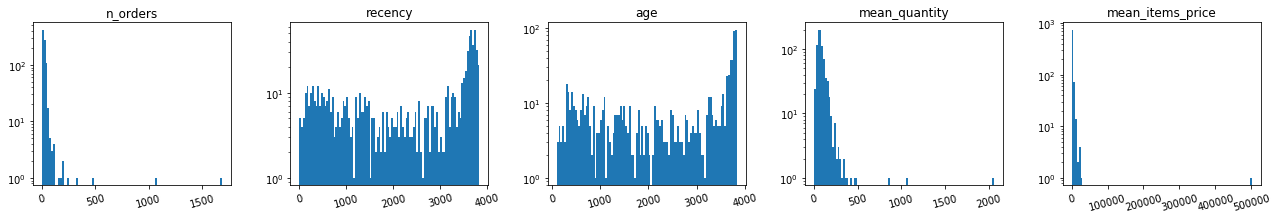

In [15]:
num_variables = ['n_orders', 'recency', 'age', 'mean_quantity', 'mean_items_price']

fig, axs = plt.subplots(1,5, figsize=(22,3))
fig.subplots_adjust(hspace = .5, wspace=.3)
axs = axs.ravel()

for i in range(len(axs)):
    axs[i].hist(df[num_variables[i]], bins=100)
    axs[i].set_yscale('log')
    axs[i].xaxis.set_tick_params(rotation=15)
    title = str(num_variables[i])
    axs[i].set_title(title)
    
plt.show()

We can spot a few outliers in `n_orders`, `mean_quantity`, `mean_items_price`. Also, none of the numerical variables are Gaussian, and one have to careful when scaling them to feed the Neural Network based model.

/Users/phil/Software/miniconda2/envs/TOTVS/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


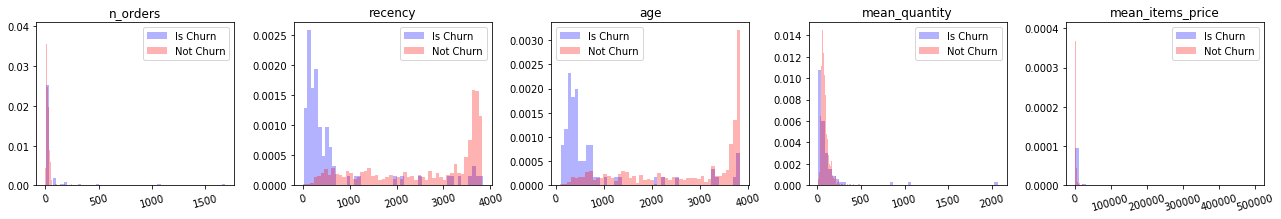

In [16]:
df_churn = df[df['is_churn']==1]
df_not_churn = df[df['is_churn']==0]

fig, axs = plt.subplots(1,5, figsize=(22,3))
fig.subplots_adjust(hspace = .5, wspace=.3)
axs = axs.ravel()

for i in range(len(axs)):
    axs[i].hist(df_churn[num_variables[i]], bins=50, alpha=0.3, color='blue', normed=True)
    axs[i].hist(df_not_churn[num_variables[i]], bins=50, alpha=0.3, color='red', normed=True)
    axs[i].xaxis.set_tick_params(rotation=15)
    title = str(num_variables[i])
    axs[i].set_title(title)
    axs[i].legend(['Is Churn', 'Not Churn'])
    
plt.show()

del df_churn
del df_not_churn

The varibles `recency` and `age` seems to have the biggest discriminative power. 

### Correlation
Now let's move to the correlation among them.

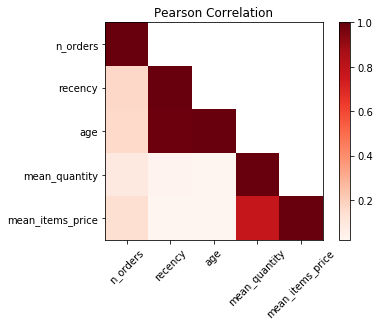

In [17]:
# Calculating the correlation matrix
num_corr = df[num_variables].corr(method='pearson')

num_corr = num_corr.where(np.tril(np.ones(num_corr.shape)).astype(np.bool))

plt.imshow(num_corr, cmap=plt.cm.Reds, interpolation='nearest')
tick_marks = [i for i in range(len(num_variables))]
plt.xticks(tick_marks, num_variables, rotation='45')
plt.yticks(tick_marks, num_variables)
plt.title('Pearson Correlation')
plt.colorbar()
plt.show()

In [18]:
num_corr

,n_orders,recency,age,mean_quantity,mean_items_price
n_orders,1.000000,NaN,NaN,NaN,NaN
recency,0.172280,1.000000,NaN,NaN,NaN
age,0.165261,0.984867,1.000000,NaN,NaN
mean_quantity,0.089408,0.028366,0.022419,1.000000,NaN
mean_items_price,0.141264,0.020779,0.020666,0.770852,1.0


We have highly correlated variables like `recency` and `age`, up to 0.98.

# Creating the Classification Model Based on Neural Networks

In [19]:
# removing missing data
df.dropna(inplace=True)

In [20]:
# Establish a benchmark: what would be your accuracy score if you predicted everyone stay?
df['is_churn'].value_counts() / len(df)

0.0    0.900978
1.0    0.099022
Name: is_churn, dtype: float64

**IMPORTANT:** Predicting **0** all the time would yield an accuracy of 90%. So the classification model has to have an accuracy higher than 90% to beat the benchmark!

With this, we also can see that the dataset is highly unbalanced.

### Convert Categorical Features

In [21]:
# convert the categorical features into binary dummy columns.
df_dummies = pd.get_dummies(df['group_code'], prefix='group_code')

X = pd.concat([df, df_dummies], axis=1, sort=False)
X.drop(columns='group_code', inplace=True)

X.head()

,n_orders,recency,age,mean_quantity,mean_items_price,is_churn,group_code_0.0,group_code_1.0,group_code_2.0
0,19.0,3545.0,3575.0,87.684211,3906.058421,0.0,1,0,0
1,42.0,3667.0,3785.0,76.595238,2944.703333,0.0,1,0,0
2,39.0,3810.0,3820.0,82.153846,2484.514615,0.0,1,0,0
3,62.0,3722.0,3783.0,163.290323,18223.666452,0.0,1,0,0
4,35.0,3617.0,3788.0,125.228571,2935.597429,0.0,1,0,0


In [22]:
y = df['is_churn']
n_samples = X.shape[0]

print('This dataset contains %i entries and %i features' % (n_samples, X.shape[1]))

This dataset contains 818 entries and 9 features


### Cross Validation

In [23]:
from sklearn.model_selection import StratifiedKFold

In [24]:
n_splits = 10
seed = 2018
folds = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed).split(X, y))

for i, fold in enumerate(folds):
    percentage_trn = (np.float(len(fold[0])) / n_samples) * 100.0
    percentage_val = (np.float(len(fold[1])) / n_samples) * 100.0
    print('Fold #%i has %1.0f%% events for training and %1.0f%% for validation.' % (i+1, percentage_trn, percentage_val))

Fold #1 has 90% events for training and 10% for validation.
Fold #2 has 90% events for training and 10% for validation.
Fold #3 has 90% events for training and 10% for validation.
Fold #4 has 90% events for training and 10% for validation.
Fold #5 has 90% events for training and 10% for validation.
Fold #6 has 90% events for training and 10% for validation.
Fold #7 has 90% events for training and 10% for validation.
Fold #8 has 90% events for training and 10% for validation.
Fold #9 has 90% events for training and 10% for validation.
Fold #10 has 90% events for training and 10% for validation.


We can see that the percentage of events in training and validation sets are the same for every fold.

### Scale Numerical Variables

In [25]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [26]:
X[num_variables] = scaler.fit_transform(X[num_variables])

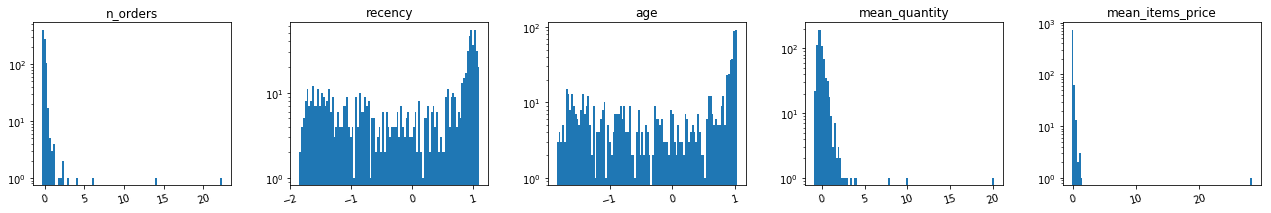

In [27]:
fig, axs = plt.subplots(1,5, figsize=(22,3))
fig.subplots_adjust(hspace = .5, wspace=.3)
axs = axs.ravel()

for i in range(len(axs)):
    axs[i].hist(X[num_variables[i]], bins=100)
    axs[i].set_yscale('log')
    axs[i].xaxis.set_tick_params(rotation=15)
    title = str(num_variables[i])
    axs[i].set_title(title)
    
plt.show()

## Neural Network Model

I'll start the analysis using a simple MLP model with only one hidden layer. I'll also apply a cross validation to estimate the statistical uncertainty of the model on the validation data. By the end of the analysis I'll check for overfitting lokking at the history of each epoch and test the classification capability of the model using a confusion matrix.

In [28]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD, Adam, Adadelta, RMSprop
import keras.backend as K

Using TensorFlow backend.


In [29]:
def load_model():
    """
    Function to create the neural network model
    """
    K.clear_session()
    model = Sequential()
    
    model.add(Dense(5, input_shape=(9,), kernel_initializer='he_normal', activation='tanh'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(Adam(lr=0.05), 'binary_crossentropy', metrics=['accuracy'])
    
    return model

Add the `EarlyStop` callback to monitor the validation loss and avoid overfitting.

In [30]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# add callbacks to the model
early_stop = EarlyStopping(monitor='val_loss', patience=3)

weights_file = 'neural_net_churn_model.hdf5'
checkpoint = ModelCheckpoint(weights_file, monitor='val_loss', save_best_only=True)

callbacks = [early_stop, checkpoint]

In [31]:
cv_scores = []
cv_hist = []

# train the model
for fold, (trn_idx, val_idx) in enumerate(folds):
    print('>> Fold %i# <<' % int(fold+1))
    
    # get training and validation data folds
    X_trn = X.values[trn_idx, :]
    y_trn = y.values[trn_idx]
    X_val = X.values[val_idx, :]
    y_val = y.values[val_idx]
    
    print('  Training on %i examples.' % X_trn.shape[0])
    print('  Validating on %i examples.' % X_val.shape[0])
    
    model = load_model()
    
    # serialize model to JSON
    if fold == 0:
        model_json = model.to_json()
        model_file = 'neural_net_churn_model.json'
        with open(model_file, 'w') as json_file:
            json_file.write(model_json)
    
    hist = model.fit(X_trn, y_trn, 
                     validation_data=(X_val, y_val), 
                     batch_size=32, 
                     epochs=20, 
                     callbacks=callbacks,
                     verbose=0)
    
    
    scores = model.evaluate(X_val, y_val)
    print('  This model has %1.6f validation accuraccy.\n' % scores[1])
    
    cv_scores.append(scores)
    cv_hist.append(hist)

>> Fold 1# <<
  Training on 735 examples.
  Validating on 83 examples.
83/83 [==============================] - 0s 34us/step
  This model has 1.000000 validation accuraccy.

>> Fold 2# <<
  Training on 736 examples.
  Validating on 82 examples.
82/82 [==============================] - 0s 37us/step
  This model has 1.000000 validation accuraccy.

>> Fold 3# <<
  Training on 736 examples.
  Validating on 82 examples.
82/82 [==============================] - 0s 37us/step
  This model has 1.000000 validation accuraccy.

>> Fold 4# <<
  Training on 736 examples.
  Validating on 82 examples.
82/82 [==============================] - 0s 35us/step
  This model has 1.000000 validation accuraccy.

>> Fold 5# <<
  Training on 736 examples.
  Validating on 82 examples.
82/82 [==============================] - 0s 39us/step
  This model has 1.000000 validation accuraccy.

>> Fold 6# <<
  Training on 736 examples.
  Validating on 82 examples.
82/82 [==============================] - 0s 32us/step
  Thi

In [32]:
val_acc = []

for metric in cv_scores:
    val_acc.append(metric[1])
    
print('Accuracy = %1.4f +- %1.4f' % (np.mean(val_acc), np.std(val_acc)))

Accuracy = 1.0000 +- 0.0000


## Getting the best model

In [33]:
model.load_weights(weights_file)

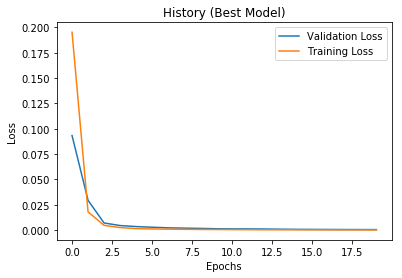

In [34]:
fig = plt.figure(figsize=(6,4))
plt.plot(model.history.history['val_loss'], label='Validation Loss')
plt.plot(model.history.history['loss'], label='Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('History (Best Model)')
plt.legend()
plt.show()

No signal of overfitting was found in the training history.

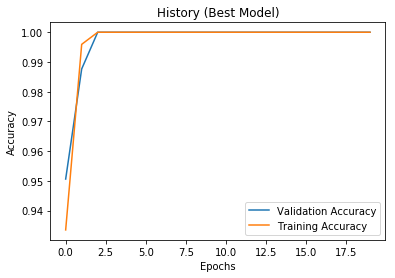

In [35]:
fig = plt.figure(figsize=(6,4))
plt.plot(model.history.history['val_acc'], label='Validation Accuracy')
plt.plot(model.history.history['acc'], label='Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('History (Best Model)')
plt.legend()
plt.show()

Both, validation and training, accuracy gets maximum value before the 5th epoch.

In [36]:
from sklearn.metrics import confusion_matrix, classification_report

In [37]:
def pretty_confusion_matrix(y_true, y_pred, labels=["False", "True"]):
    cm = confusion_matrix(y_true, y_pred)
    pred_labels = ['Predicted '+ l for l in labels]
    df = pd.DataFrame(cm, index=labels, columns=pred_labels)
    return df

# check the confusion matrix for a particular fold
fold = 0

print('>> Confusion Matrix for the %i fold. <<\n' % (fold+1))

y_test = y.iloc[folds[fold][1]]
y_test_pred = model.predict_classes(X.iloc[folds[fold][1], :])

pretty_confusion_matrix(y_test, y_test_pred, labels=['Not Churn', 'Churn'])

>> Confusion Matrix for the 1 fold. <<



,Predicted Not Churn,Predicted Churn
Not Churn,74,0
Churn,0,9


One can also check the confusion matrix for every other fold used during cross validation.

In [38]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        74
         1.0       1.00      1.00      1.00         9

   micro avg       1.00      1.00      1.00        83
   macro avg       1.00      1.00      1.00        83
weighted avg       1.00      1.00      1.00        83



## Conclusion

With a simple MLP model we could predict the churning rate of each customer on the dataser with 100% accuracy on the test set.